# Eine Analyse von Verkäufen des Onlineshops 


In [1]:
shop_name='brands4***' # Hier fängts an
num_bestsellers=30
email=''


In [2]:
real_sales = True
feedback_quote=2.5
shop_category='Haushalt'

if email:
    password ='!Eli***33oG' # input('Password eingeben: ') #'!El***33oG'

In [3]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.0f' % x) # show only decimal number 

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import shutil
import os
import re
import warnings
import subprocess
import sys
import time
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('classic')
plt.rcParams['grid.color'] = (0.9, 0.9, 0.9, 0.1)   


In [4]:
if shop_category=='Haushalt': xytext_x=200
elif shop_category=='Werkzeug': xytext_x=500
elif shop_category=='Technik': xytext_x=300
else: xytext_x=400
               
categories={'Werkzeug':{'bins':200,'y_max_rate':0.2,'x_max_rate':3},
            'Technik':{'bins':250,'y_max_rate':0.1,'x_max_rate':3},
            'Haushalt':{'bins':250,'y_max_rate':0.5,'x_max_rate':5},}

german_stopwords=stopwords.words('german')
german_stopwords.extend(['for','ideal','satz','forum','BOX','BIT','GBA','SDS','GAL','GSR','PLUS','GST','GKS','TPN','EUR','set','neue','alte','Akku','Watt','GSA','teilig'])


In [5]:
names = {'card__item':'Artikelname',
         'card__price':'Artikelpreis',
         'tablescraper-selected-row':'Zeitraum',
         'card__item 2':'Artikelnummer',
         'card__item href':'Artikel_link'}

In [6]:
def create_last6months_table(shop):
    
    df6 = pd.read_csv(f"./{shop}6.csv", usecols=['card__item',
                                             'card__item 2',
                                             'card__item href',
                                             'card__price',
                                             'tablescraper-selected-row'])
    #rename column name
    df6.rename(names,inplace=True,axis=1)  
    #select only last six month data
    df6 = df6.loc[df6['Zeitraum'].isin(['Letzter Monat','Letzte 6 Monate']),:] 
    return df6

df6 = create_last6months_table(shop_name)


In [7]:
def create_6_12months_table(shop):
    
    df6_12=pd.read_csv(f"./{shop}12.csv", usecols=['card__item',
                                                  'card__price',
                                                  'tablescraper-selected-row'])

    df6_12['card__item href']=np.nan  # create columns as in table last six months
    df6_12['card__item 2']=np.nan   # create columns as in table last six months
    df6_12.rename(names,inplace=True,axis=1)
    df6_12 = df6_12.loc[df6_12['Zeitraum']=='Letztes Jahr',:] # six months before last six months
    
    return df6_12

df6_12 = create_6_12months_table(shop_name)


In [8]:
df = pd.concat([df6,df6_12],ignore_index=True) # concatenate to full data
df

,Artikelname,Artikelnummer,Artikel_link,Artikelpreis,Zeitraum
0,2x FEBI BILSTEIN KOPPELSTANGE PENDELSTÜTZE VOR...,362438334361,https://www.ebay.de/itm/362438334361,"EUR 24,79",Letzter Monat
1,4x BOSCH ZÜNDKERZE IRIDIUM FÜR SEAT ALTEA 5P 0...,361958266450,https://www.ebay.de/itm/361958266450,"EUR 32,20",Letzter Monat
2,MANN INSPEKTIONSPAKET+5L LIQUIMOLY FÜR AUDI A3...,294630599462,https://www.ebay.de/itm/294630599462,"EUR 82,50",Letzter Monat
3,MEYLE 2x SPURSTANGENKOPF FÜR FORD GALAXY MONDE...,363597088086,https://www.ebay.de/itm/363597088086,"EUR 37,90",Letzter Monat
4,FEBI PUMPE WASCHWASSER SCHEIBENWISCHWASSERPUMP...,363061068166,https://www.ebay.de/itm/363061068166,"EUR 15,69",Letzter Monat
...,...,...,...,...,...
150830,EXIDE AUTOBATTERIE 12V 80Ah STARTERBATTERIE 80...,NaN,NaN,"EUR 122,90",Letztes Jahr
150831,2x 1 L LITER CASTROL EDGE FLUID TITANIUM 5W-40...,NaN,NaN,"EUR 26,36",Letztes Jahr
150832,6x NGK ZÜNDKERZE ZÜNDKERZEN FÜR BMW 3-ER E36 5...,NaN,NaN,"EUR 23,95",Letztes Jahr
150833,BOSCH ÖLFILTER+10L CASTROL EDGE FLUID 5W-30 LL...,NaN,NaN,"EUR 102,44",Letztes Jahr


In [9]:
def short_item_name(text, words=3):
    
    #pattern=r'\b\w+\b' # pattern to find words
    pattern =r'\b[a-zA-Z]{3,20}\b'
    match = re.findall(pattern,text)
    text = ' '.join(match[:words]) # show only some words
    return text

In [10]:
def convert_datatype(df):
    
    df['Preis_EUR'] = df.Artikelpreis.str.split(expand=True)[1] # remove EUR
    df['Preis_EUR'] = df.Preis_EUR.str.replace('$','')
    df['Preis_EUR'] = df.Preis_EUR.str.replace('.','')
    df['Preis_EUR'] = df.Preis_EUR.str.replace(',','.')
    df['Preis_EUR'] = df.Preis_EUR.astype(float)
    df.drop('Artikelpreis',inplace=True,axis =1)
    return df

In [11]:
def split_number(text):
    
    match = re.search(r'[0-9]{12}',str(text))
    return match.group() if match else None
    

In [12]:
def remove_item_number(text):
    """ function to remove item number from description"""
    text = str(text)
    pattern1 = r'[0-9]{12}'
    pattern2 = r'\(Nr\.'
    text = re.sub(r'\)','',text)    # remove ')'
    text = re.sub(pattern1,'',text) # remove item number
    text = re.sub(pattern2,'',text) # remove (Nr .
    
    return text


In [13]:
def fill_nan(df):
    
    df['Artikelnummer_temp'] = df['Artikelname'].apply(split_number)
    nan_index = df[df['Artikelnummer'].isnull()].index
    df.loc[nan_index,'Artikelnummer']=df.loc[nan_index,'Artikelnummer_temp'] # fill item number
    df.loc[nan_index,'Artikel_link'] = 'https://www.ebay.de/itm/'+ \
                                        df.loc[nan_index,'Artikelnummer'] # fill links
    df.drop('Artikelnummer_temp',axis = 1, inplace= True)
    df.dropna(inplace=True)
    
    return df


In [14]:
def format_table(df):
    
    df = convert_datatype(df)
    df = fill_nan(df) # fill nan value in item number and item link column
    df['Artikelname'] = df['Artikelname'].apply(remove_item_number) # remove item number from item description
    df.Artikelnummer=df.Artikelnummer.astype(int) # convert item number to type int
    print(f'{df.isnull().sum().sum()} NaN value(s) after dropna')

    return df



In [15]:
def create_best_sellers(df,count):
    
    letzter_monat = df.loc[df['Zeitraum'].isin(['Letzter Monat']),'Artikel_link'].value_counts()
    letzte_6_monate= df.loc[df['Zeitraum'].isin(['Letzte 6 Monate']),'Artikel_link'].value_counts()
    letzte_6_12_monate = df.loc[df['Zeitraum'].isin(['Letztes Jahr']),'Artikel_link'].value_counts()

    best_sellers = pd.concat([letzter_monat,letzte_6_monate,letzte_6_12_monate],axis=1)
    best_sellers.columns.values[0]='Verkäufe letztes Monats in Stück'
    best_sellers.columns.values[1]='Verkäufe vor 1-6 Monat in Stück'
    best_sellers.columns.values[2]='Verkäufe vor 6-12 Monat in Stück'

    best_sellers['Durchschnittliche Verkäufe letzter 6 Monate' ]=best_sellers['Verkäufe vor 1-6 Monat in Stück']/5 
    best_sellers['Durchschnittliche Verkäufe vor 6-12 Monat']=best_sellers['Verkäufe vor 6-12 Monat in Stück']/6 
    best_sellers['Durchschnittliche Verkäufe letzter 12 Monate']=(best_sellers['Verkäufe vor 1-6 Monat in Stück']\
                                                        + best_sellers['Verkäufe vor 6-12 Monat in Stück'])/11

    best_sellers= best_sellers.iloc[:count,:]
    
   

    best_sellers= best_sellers.reset_index().merge(df.loc[:,['Artikelname','Artikel_link','Preis_EUR','Artikelnummer']].\
                                                   drop_duplicates().set_index('Artikel_link'),
                                                   left_on='index', right_on='Artikel_link')        
    best_sellers_index= best_sellers['index'].drop_duplicates().index
    
    return best_sellers.loc[best_sellers_index,:].reset_index(drop = True)
    

In [16]:
def create_revenue_columns(df):
    
    df['Umsatz/Monat'] = df['Verkäufe letztes Monats in Stück']*df['Preis_EUR']
    df['Umsatz/6_Monate'] = df['Durchschnittliche Verkäufe letzter 6 Monate']*5*df['Preis_EUR']+df['Umsatz/Monat']
    df['Umsatz/12_Monate'] = df['Durchschnittliche Verkäufe letzter 12 Monate']*11*df['Preis_EUR']+df['Umsatz/Monat']
    return df
    

In [17]:
def change_datatype_to_int(df):
    
    df.fillna(0,inplace=True)
    columns=['Verkäufe letztes Monats in Stück','Durchschnittliche Verkäufe letzter 6 Monate',
           'Durchschnittliche Verkäufe letzter 12 Monate','Umsatz/Monat','Umsatz/6_Monate','Umsatz/12_Monate']
    for column in columns:
        df[column]=df[column].round().astype(int)
    return df


In [18]:
def write_to_file(df):
    
    global path
    path=f'Verkaufsanalyse_{shop_name}'
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)
    
    change_datatype_to_int(df)
    df=df.rename(columns= {'index':'Art_Link'})
    df=df.loc[:,['Artikelname','Preis_EUR', 'Verkäufe letztes Monats in Stück',
                'Durchschnittliche Verkäufe letzter 6 Monate','Durchschnittliche Verkäufe letzter 12 Monate',
                'Umsatz/Monat','Umsatz/6_Monate','Umsatz/12_Monate','Art_Link','Artikelnummer']]
    df.to_csv(f'{path}/{shop_name}_{num_bestsellers}_bestsellers.csv')
    
    return df

In [19]:
formated_table = format_table(df)
best_sellers = create_best_sellers(formated_table,num_bestsellers)
final_df = create_revenue_columns(best_sellers)
final_df = write_to_file(final_df)
final_df['Art_Name'] = final_df.Artikelname.apply(short_item_name)

0 NaN value(s) after dropna


In [20]:
def plot_monthly_sales(df,true_sales=True):
    
    bestsellers = df.loc[df['Zeitraum']=='Letzter Monat','Artikelname']\
        .value_counts()[:num_bestsellers]
                       
    bestsellers = bestsellers * feedback_quote if true_sales else bestsellers
    ax = bestsellers.plot(kind='barh',
                          figsize=(16,15),
                          color="#0bff01",
                          width=0.7,
                          edgecolor='black'
                          )
    plt.tick_params(
                    axis='both',       # changes apply to the x and y-axis
                    which='both',      # both major and minor ticks are affected
                    right=False,       # ticks along the bottom edge are off
                    top=False,         # ticks along the top edge are off

                        )
    ax.text(0.55, 0.95, 'Verkaufsmenge letztes Monats', fontdict={'fontsize':20, 'fontweight' :'bold'},
            transform=ax.transAxes, bbox=dict(facecolor='#0bff01', alpha=0.5)
           )


    plt.savefig(f'{path}/Verkaufsmenge letztes Monates(1).pdf',bbox_inches='tight')
    


In [21]:
def plot_yearly_sales(df,true_sales=True):
    
    bestsellers = df.loc[:,['Artikelname','Preis_EUR']].value_counts()[:num_bestsellers]
    bestsellers = feedback_quote*bestsellers if true_sales else bestsellers
    
    ax = bestsellers.plot(kind='barh',
                      figsize=(15,15),
                      color="#fdfe02",
                      width=0.7,
                      edgecolor='black',
                      )
    plt.tick_params(
                    axis='both',        
                    which='both',      
                    right=False,      
                    top=False,         
                    )
    ax.text(0.55, 0.95, 'Verkaufsmenge letztes Jahres', 
            fontdict={'fontsize':20, 'fontweight' :'bold'},
            transform=ax.transAxes, bbox=dict(facecolor='#fdfe02', alpha=0.5)
           )
    plt.savefig(f'{path}/Verkaufsmenge letztes Jahres().pdf',bbox_inches='tight')
  

In [22]:
def plot_turnover_volume(df,num = 25,true_sales = True):
    
    fig,ax = plt.subplots(1,1,figsize=(20,12))
    df['Umsatz/Monat']= feedback_quote * df['Umsatz/Monat'] if true_sales else df['Umsatz/Monat']
    ax = sns.barplot(data=df,
                y='Umsatz/Monat',x='Artikelname');
    ax.set_xlabel('Umsatzstarke Produkte',fontdict={'fontsize':16,'fontweight':'bold'})
    ax.set_ylabel('Umsatz pro Monat in EUR',fontdict={'fontsize':16,'fontweight':'bold'})
    ax.set_xticklabels(df.Artikelname, rotation = 30, ha="right");
    ax.set_title('Umsatz je Produkt pro Monat',fontdict={'fontsize':25,'fontweight':'bold'})
    ax.yaxis.grid()
    ax.set_facecolor('grey')
    
    plt.savefig(f'{path}/Umsatz je Produkt pro Monat(5).pdf',bbox_inches='tight')


In [23]:
def comparedplot(df,true_sales=True):
    
    bestsellers=df.set_index('Artikelname').loc[:,['Verkäufe letztes Monats in Stück',
                           'Durchschnittliche Verkäufe letzter 6 Monate',
                           'Durchschnittliche Verkäufe letzter 12 Monate']]
    bestsellers = bestsellers*feedback_quote if true_sales else bestsellers
    ax=bestsellers.plot(kind='barh',
                    figsize=(15,30),
                    color=['#0bff01','#fe0000','#fdfe02'],
                    edgecolor='black',
                    width=0.9,
                    alpha = 0.8
                    )


    plt.savefig(f'{path}/Verkaufsanzahlvergleich().pdf',bbox_inches='tight')
    

In [24]:
def trend_comparedplot(df,true_sales=True):
    bestsellers=df.set_index('Artikelname').loc[:,['Verkäufe letztes Monats in Stück',
                           'Durchschnittliche Verkäufe letzter 6 Monate',
                           'Durchschnittliche Verkäufe letzter 12 Monate']]
    bestsellers = bestsellers*feedback_quote if true_sales else bestsellers
    ax=bestsellers.plot(kind='barh',
                    figsize=(15,30),
                    color=['#0bff01','#fe0000','#fdfe02'],
                    edgecolor='black',
                    width=0.9,
                    alpha = 0.3
                    ); 

    for i in range(len(df.index)):
        color1 ='g' if (df.iloc[i,3]/2>df.iloc[i,4]/2) else 'r' 
        color2= 'g' if (df.iloc[i,2]/2>df.iloc[i,3]/2) else 'r' 
        if true_sales:
            ax.annotate('',xy =( df.iloc[i,3]*2,df.index[i]),
                            xytext =(df.iloc[i,4]*2,df.index[i]+0.3), 
                            arrowprops = dict(color =color1,
                                              arrowstyle='-',
                                              #width=1
                                             ))
            ax.annotate('',xy =( df.iloc[i,2]*2,df.index[i]-0.3),
                            xytext =(df.iloc[i,3]*2,df.index[i]), 
                            arrowprops = dict(color =color2,
                                              #arrowstyle='->',
                                             width=1
                                             ))
        else:    
            ax.annotate('',xy =( df.iloc[i,3]/2,df.index[i]),
                            xytext =(df.iloc[i,4]/2,df.index[i]+0.3), 
                            arrowprops = dict(color =color1,
                                              arrowstyle='-',
                                              #width=1
                                             ))
            ax.annotate('',xy =( df.iloc[i,2]/2,df.index[i]-0.3),
                            xytext =(df.iloc[i,3]/2,df.index[i]), 
                            arrowprops = dict(color =color2,
                                              #arrowstyle='->',
                                             width=1
                                             ))
    ax.text(0.7, 0.94, ' --->' , 
            transform=ax.transAxes,color ='g',fontsize=18 )
    ax.text(0.76, 0.94, ' Nachfrage steigt', 
            transform=ax.transAxes,fontsize=15  )
    ax.text(0.7, 0.92, ' --->' , 
            transform=ax.transAxes,color ='r',fontsize=18 )
    ax.text(0.76, 0.92, ' Nachfrage sinkt', 
            transform=ax.transAxes,fontsize=15  )       

    plt.savefig(f'{path}/Verkaufstrend(3).pdf',bbox_inches='tight')

   

In [25]:
def plot_product_revenue(df,num=25):
    
    fig,ax = plt.subplots(1,1,figsize=(20,15))
    explode = np.zeros(num)
    explode[0]= 0.1
    labels= df.sort_values('Umsatz/12_Monate',ascending=False)[:num].Art_Name
    ax.pie(df['Umsatz/12_Monate'].sort_values(ascending=False)[:num],
                                                    labels=labels,
                                                    #shadow=True,
                                                    radius=1.2,
                                                    explode=explode,
                                                    autopct='%1.1f%%',
                                                    textprops={'fontsize':16,'color':'black' },
                                                    wedgeprops = {"alpha": 0.9,
                                                                 'linewidth': 3});
    ax.set_title('Prozentualer Anteil am Verkauf pro Jahr',loc ='center', fontdict={'fontsize':30,'color':'orange'})
    
    plt.savefig(f'{path}/prozentualer Anteil am Verkauf(2).pdf',bbox_inches='tight')


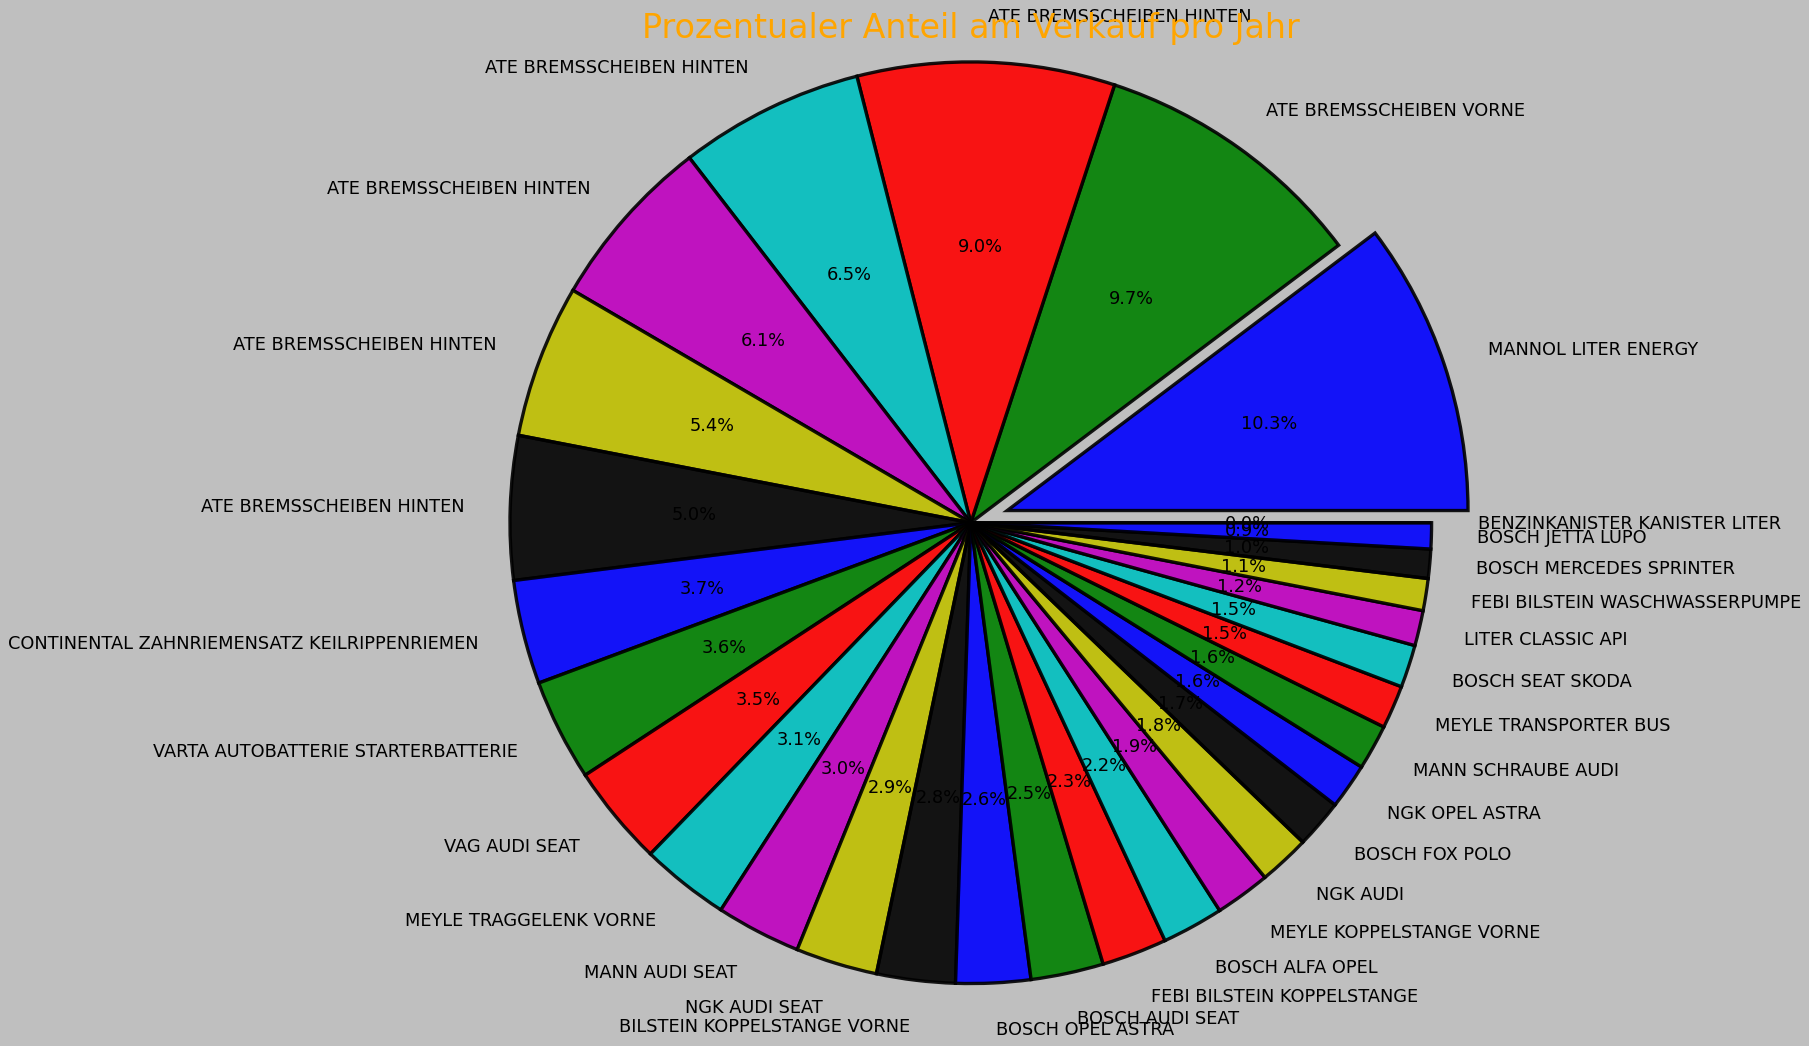

In [26]:
plot_product_revenue(final_df,num=num_bestsellers)

In [27]:
def plot_boxplot(df):
    
    plt.style.use('classic')
    fig,ax=plt.subplots(1,1,figsize=(27.5,12))
    ax = sns.boxplot(data=df,x='Preis_EUR',color='#0bff01')
    
    quantile_1=round(df.Preis_EUR.quantile(0.25))
    quantile_3=round(df.Preis_EUR.quantile(0.75))
    
                                
    ax.set_xticks(range(0,round(df.Preis_EUR.max()/100)*100,50))
    ax.annotate(f'50% des Umsatzes erzielt durch Verkauf von Produkten zw. {quantile_1} - {quantile_3} EUR ',
                xy =(quantile_3, 0.4),
                xytext =(500, 0.45), 
                arrowprops = dict(facecolor ='red',
                                  shrink = 0.05),)
    plt.xticks(rotation=90);
    plt.tick_params(
                    axis='x',          
                    which='both',           
                    top=False,         
                   ) 
    plt.savefig(f'{path}/Preisspanne die 50% Umsatz generiert(8).pdf',bbox_inches='tight')
    


In [28]:
def plot_price_distribution(df,bins=200,x=500,y=10000):

    plt.style.use('dark_background')
    fig,ax = plt.subplots(1,1,figsize=(22,12))
    ax.hist(df.Preis_EUR,bins=bins,color='#0bff01',alpha = 0.8, lw=3);
    ax.set_title(f'Gesamtjahresumsatz von {shop_name}', fontdict={'family': 'serif',
                                                        
                                                         'weight': 'normal',
                                                          'size': 30,
                                                          })
    ax.set_xlim(0,x)
    ax.set_xticks(range(0,x,int(x/20)))
    ax.set_xlabel("Preisspanne in EUR",fontweight='bold',fontsize=15)
    
    ax.set_ylim(0,y)
    ax.set_yticks(range(0,y,int(y/20)))
    ax.set_ylabel("Anzahl verkaufter Produkte",fontweight='bold',fontsize=15)
   
    ax.text(x/3,6*y/7,f'  eBay ca. {round(df.Preis_EUR.sum()*4/1000000,2) } Mio EUR \
                        \n Amazon ca. {round(df.Preis_EUR.sum()*40/1000000,2) } Mio EUR',
                                                        fontdict={'family': 'serif',
                                                         'color':  'red',
                                                         #'weight': 'normal',
                                                          'size': 30,
                                                          'fontweight':'bold'}) 
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.grid(False)
    plt.tick_params(
                    axis='both',       # changes apply to the x and y-axis
                    which='both',      # both major and minor ticks are affected
                    right=False,       # ticks along the bottom edge are off
                    top=False,         # ticks along the top edge are off
                    #labelbottom=False
                    ) 
    plt.tight_layout()
    plt.savefig(f'{path}/Gesamtumsatz(7).pdf',bbox_inches='tight')


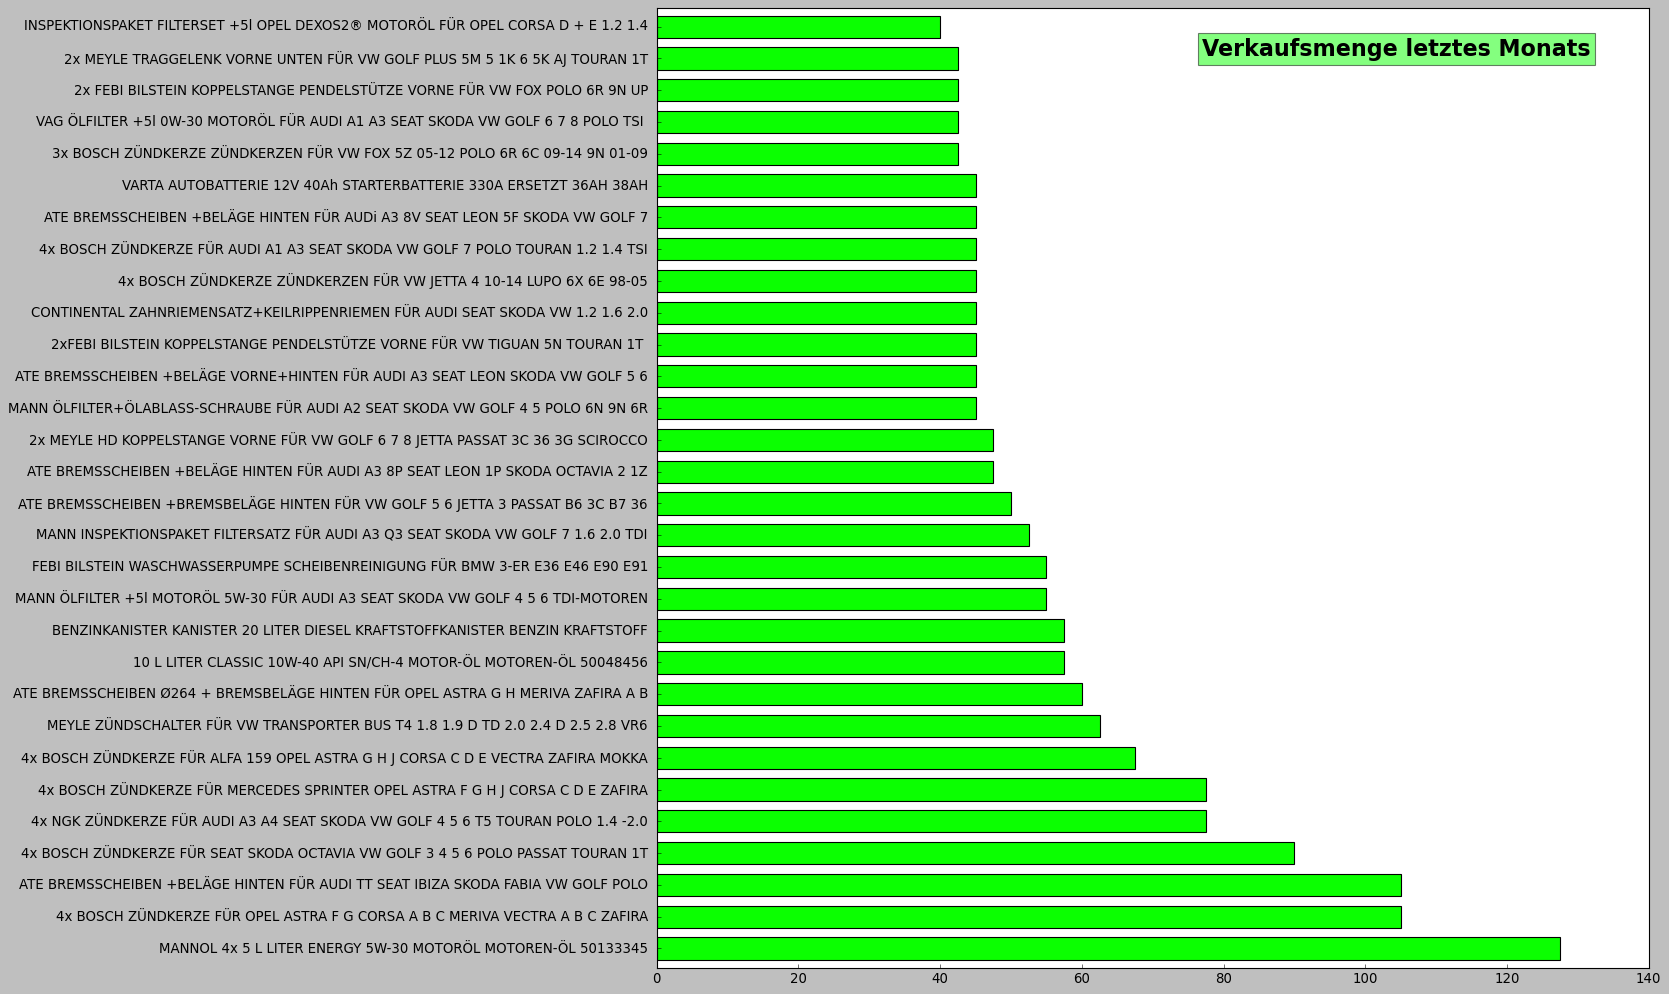

In [29]:
plot_monthly_sales(df,true_sales=real_sales)

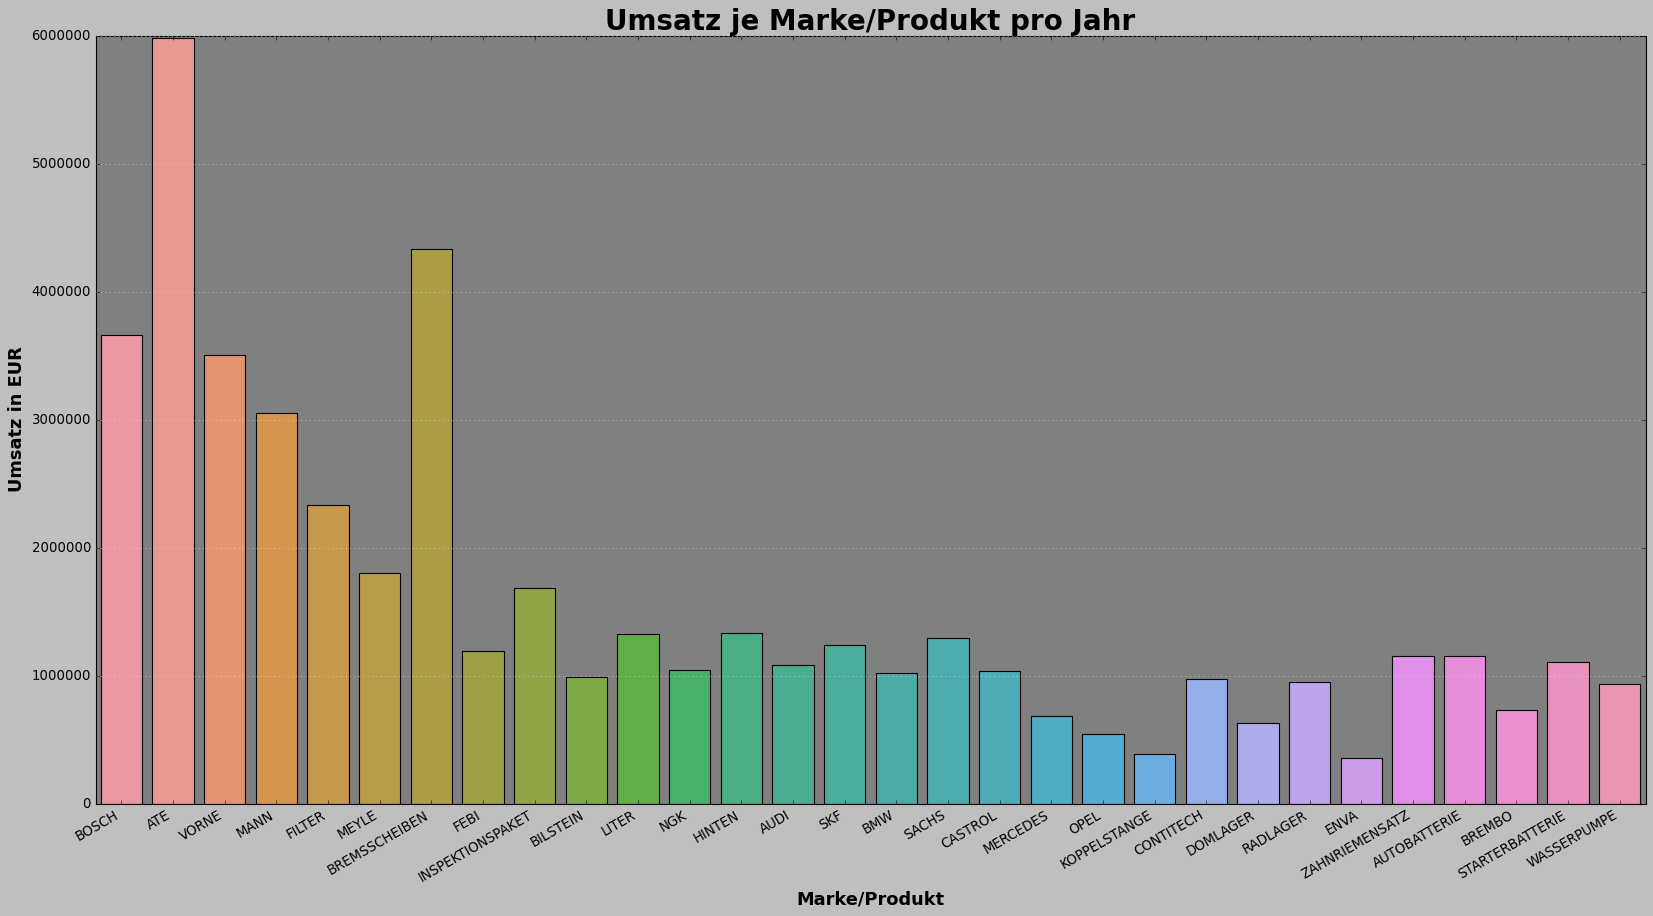

In [30]:
def create_corpus(df):
    corpus=[]
    
    for x in df['Artikelname'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

def plot_bestbrands(df,true_sales=True):
    
    
    global german_stopwords
    german_stopwords=[word.upper() for word in german_stopwords]
    df.Artikelname=df.Artikelname.apply(short_item_name,10)
    corpus=create_corpus(df)
    corpus=[word.upper() for word in corpus]
    words_series=pd.Series(corpus)
    words_series=words_series.value_counts(ascending=False)[:]
    words_series.drop(labels=german_stopwords,errors='ignore',inplace=True)
    mostfrequent_words = words_series.head(30)
    most_revenues={}
    for i in range(len(mostfrequent_words)):

        product=mostfrequent_words.index[i]
        total =df.loc[df.Artikelname.str.upper().str.contains(product),'Preis_EUR'].sum()
        most_revenues[product]=round(total)
    
    most_revenue_brands=pd.DataFrame(most_revenues.items(),columns=['Marke/Produkt','Total_Verkaufsumme'])
    most_revenue_brands['Total_Verkaufsumme'] = 4*most_revenue_brands['Total_Verkaufsumme'] if true_sales else most_revenue_brands['Total_Verkaufsumme']
                                     
    fig,ax = plt.subplots(1,1,figsize=(25,12))
    ax = sns.barplot(data=most_revenue_brands,
                y='Total_Verkaufsumme',x='Marke/Produkt');
    ax.set_xlabel('Marke/Produkt',fontdict={'fontsize':16,'fontweight':'bold'})
    ax.set_ylabel('Umsatz in EUR',fontdict={'fontsize':16,'fontweight':'bold'})
    ax.set_xticklabels(most_revenue_brands['Marke/Produkt'], rotation = 30, ha="right");
    ax.set_title('Umsatz je Marke/Produkt pro Jahr',fontdict={'fontsize':25,'fontweight':'bold'})
    ax.yaxis.grid()
    ax.set_facecolor('grey')
    
    plt.savefig(f'{path}/Umsatz je Marke-Produkt pro Jahr(5).pdf',bbox_inches='tight')
plot_bestbrands(df,true_sales=real_sales)

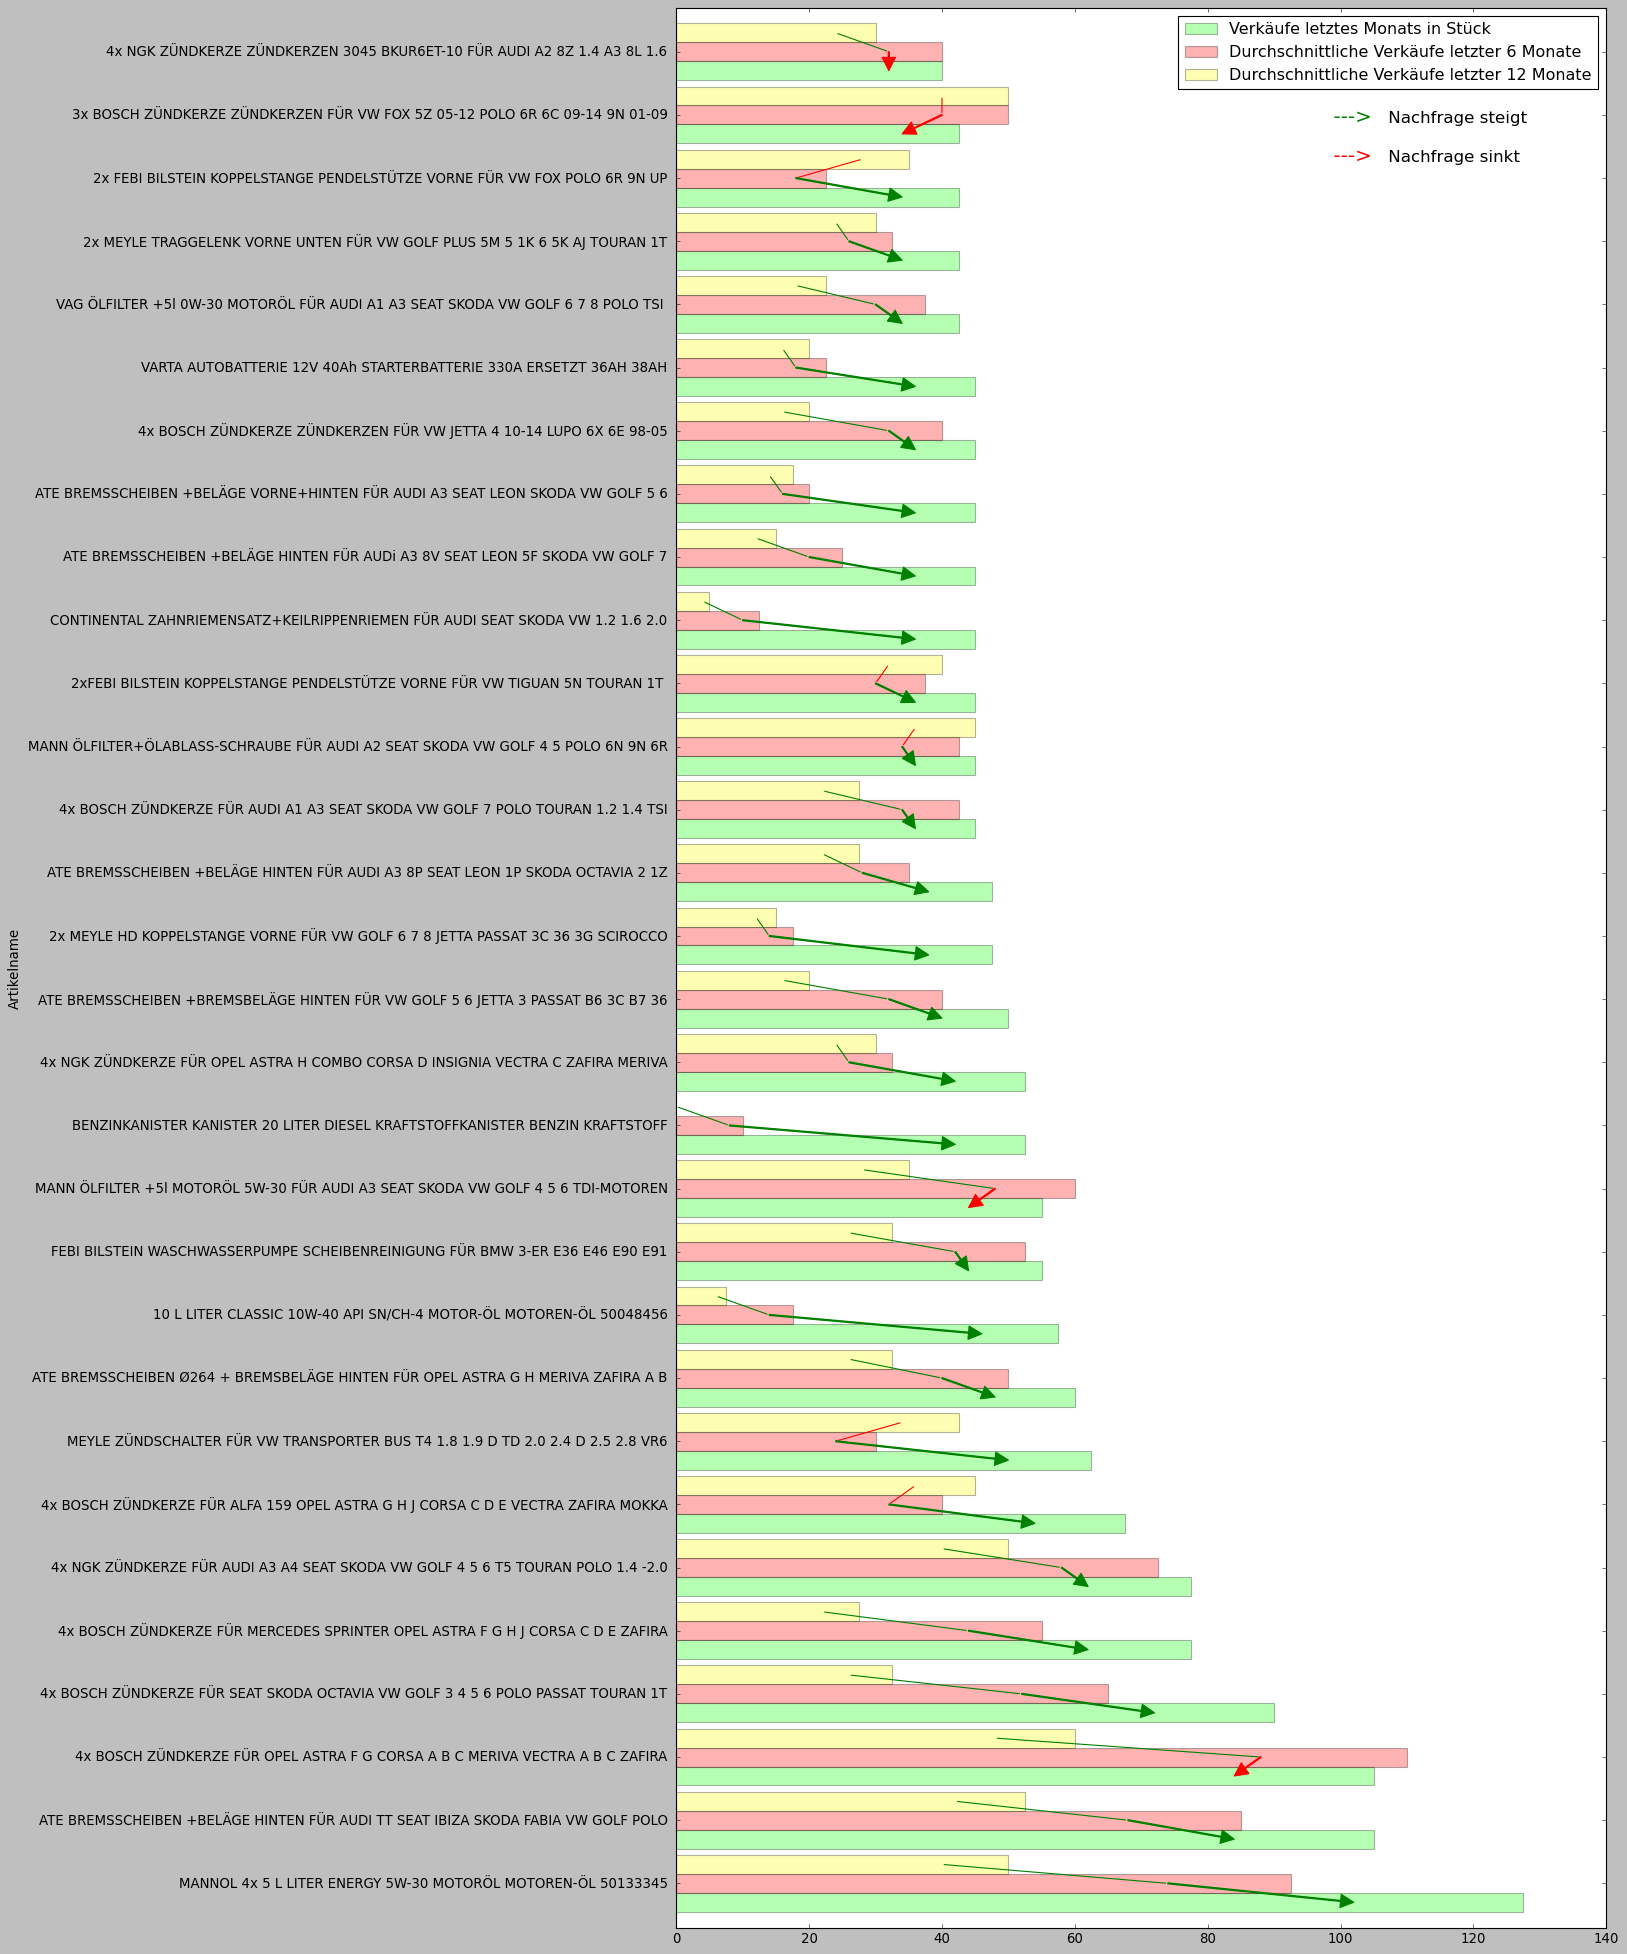

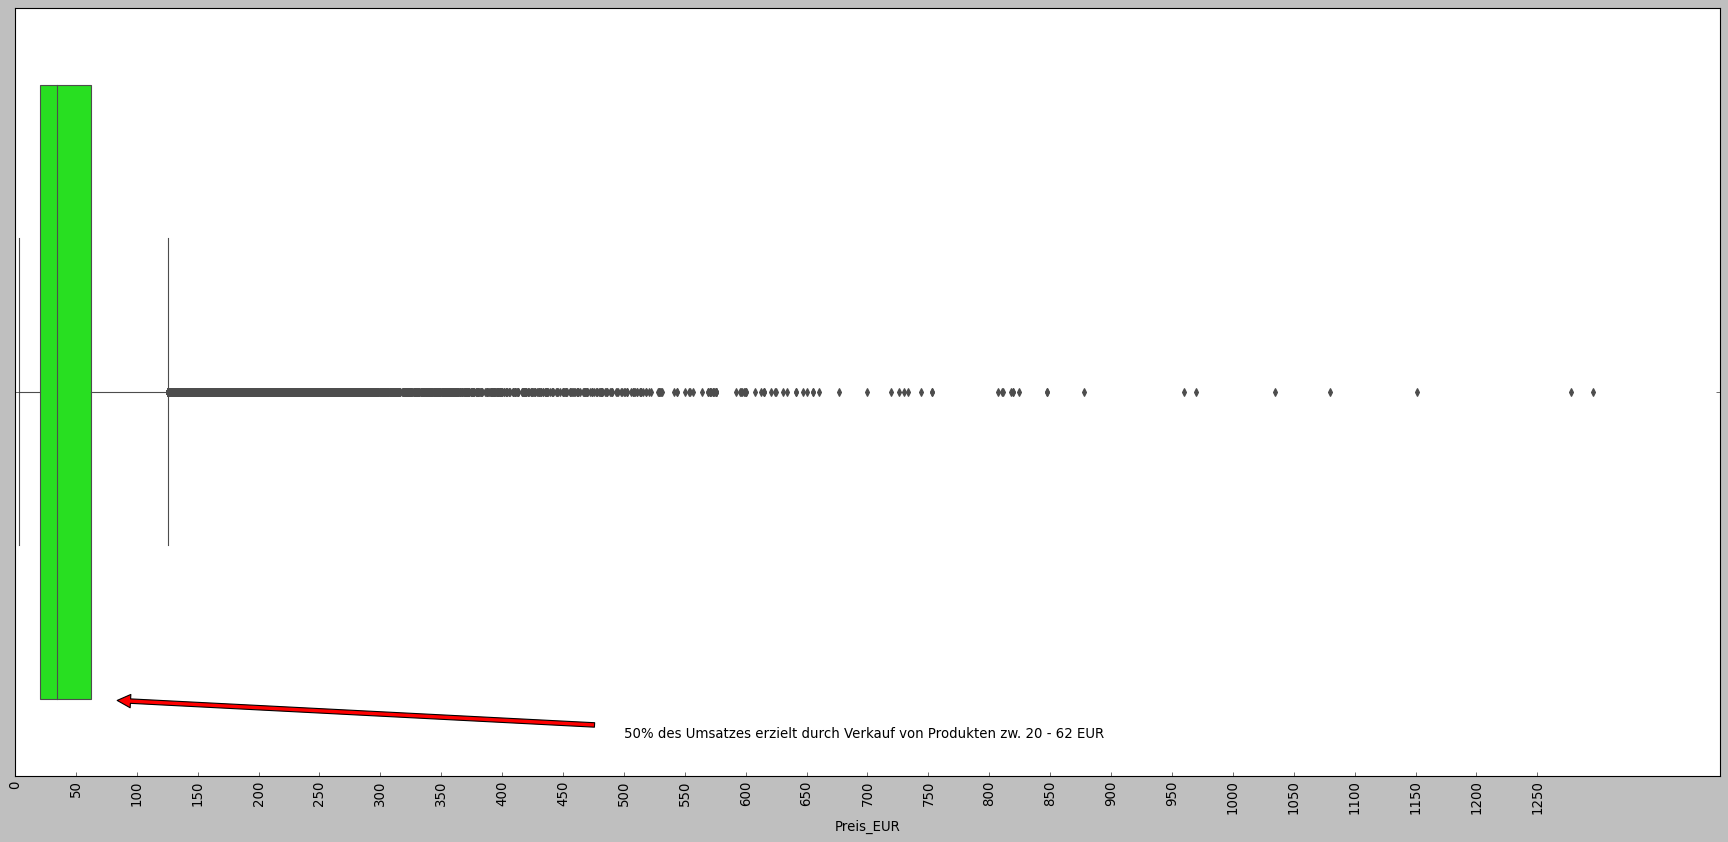

In [31]:
#'Werkzeug':{'bins':200,'y_max_rate':0.2,'x_max_rate':3},
#'Technik':{'bins':200,'y_max_rate':0.1,'x_max_rate':3},
#'Haushalt':{'bins':250,'y_max_rate':0.5,'x_max_rate':5},

#plot_yearly_sales(df,true_sales=real_sales)
#comparedplot(final_df,true_sales=real_sales)
trend_comparedplot(final_df,true_sales=real_sales)
                                              
#plot_product_revenue(final_df)
plot_boxplot(df)


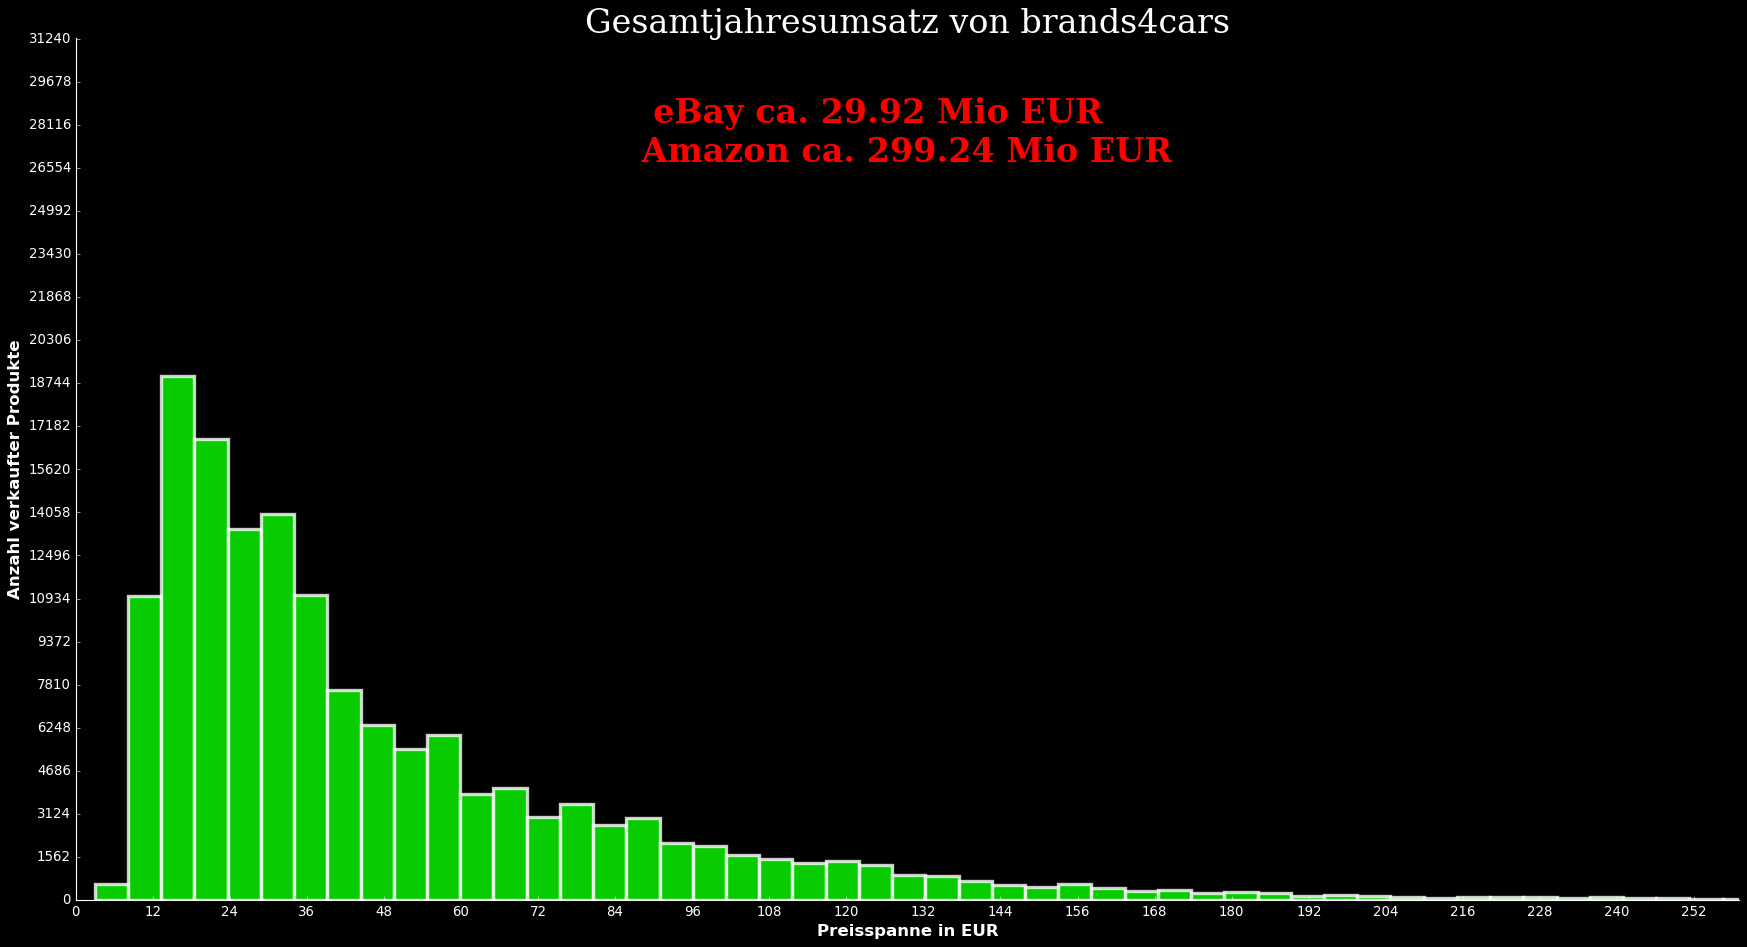

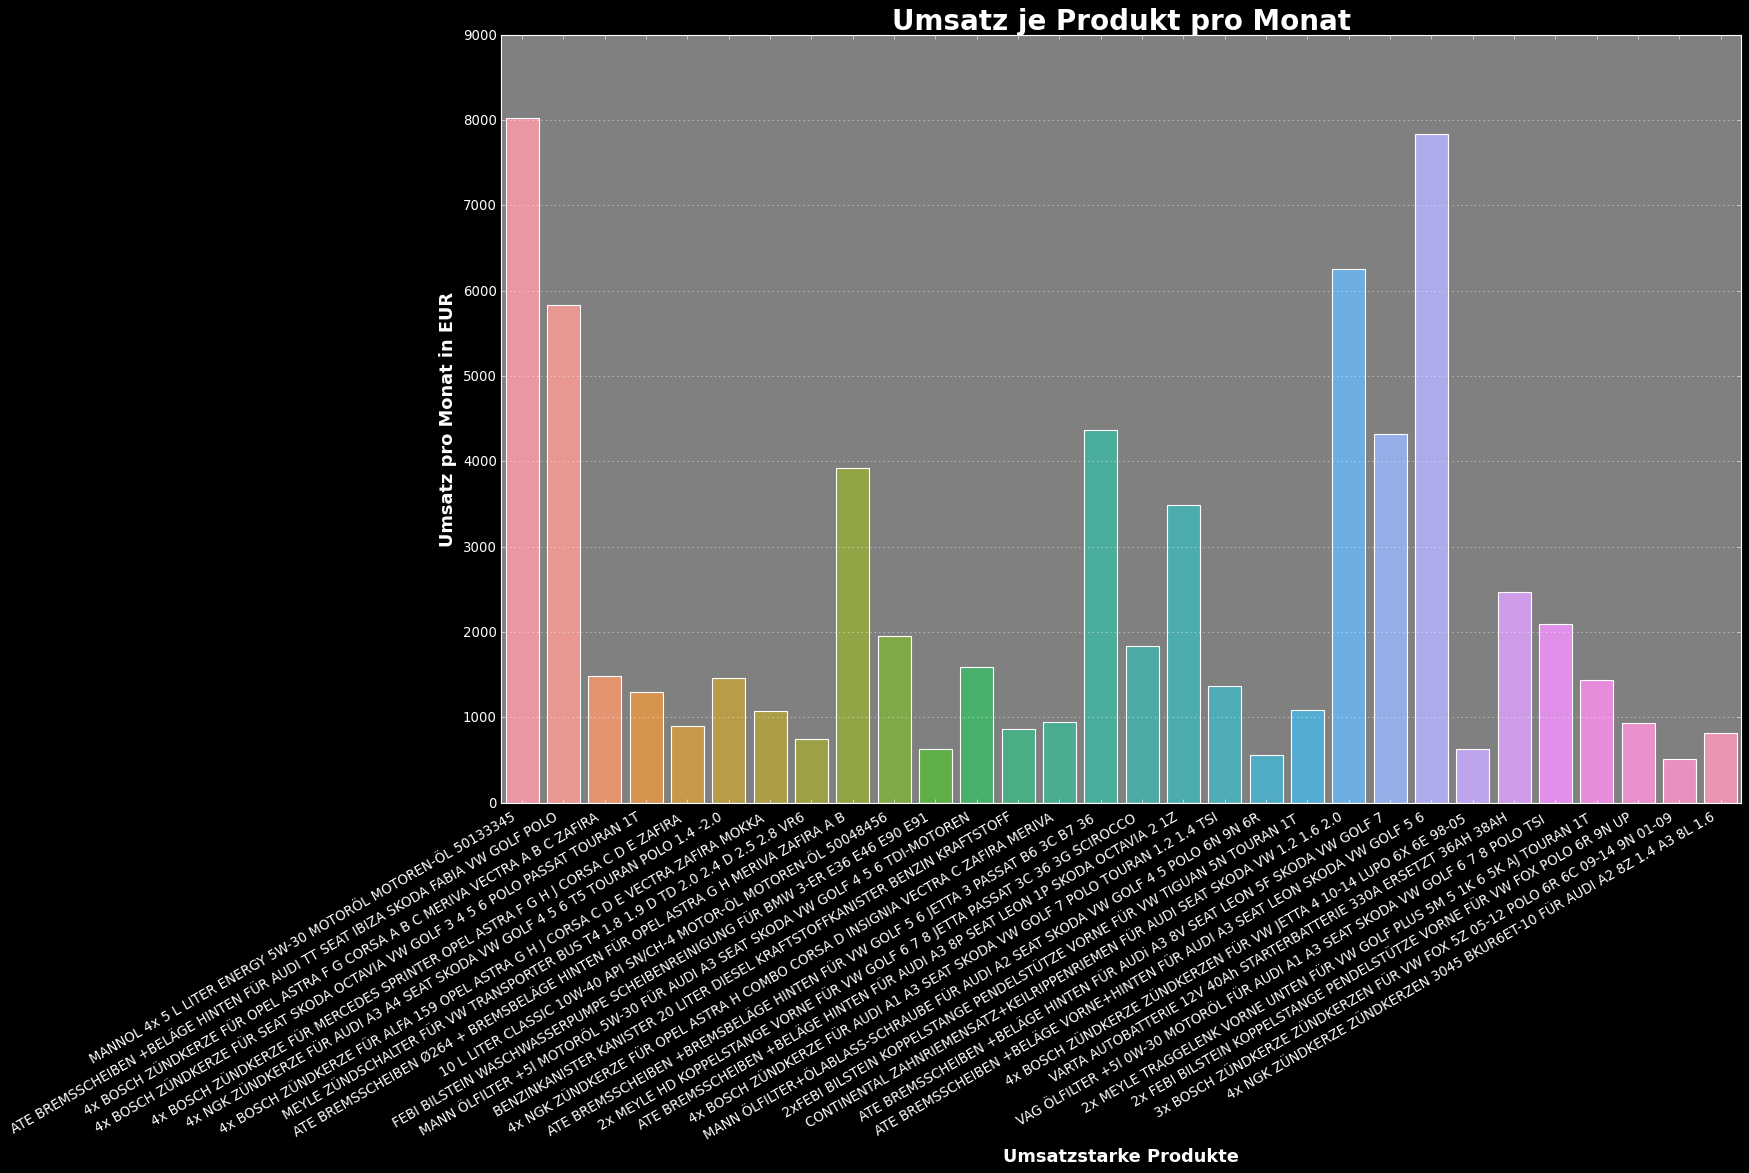

In [32]:
#bins=100
#bins=150
bins=categories[shop_category]['bins']
x_max=df.Preis_EUR.max()/categories[shop_category]['x_max_rate']
y_max=categories[shop_category]['y_max_rate']*bins**2
plot_price_distribution(df,bins=bins,y=round(y_max),x=round(x_max))
plot_turnover_volume(final_df) 

In [33]:
def merge_pdfs(source_dir,shop=''):
    
    from PyPDF2 import PdfFileMerger
    merger = PdfFileMerger()
    files = os.listdir(source_dir)
    pdfs = [file for i in range(len(files)) for file in files if ('('+ str(i+1)+')') in file and file.endswith('pdf')]
    for pdf in pdfs:
        #if pdf.endswith('pdf'):
        merger.append(source_dir +'/'+ pdf)

    merger.write(source_dir + f'/Verkaufsanalyse_von_{shop}.pdf')       
    merger.close()

In [34]:
def send_email_with_attachment(password, receiver='quoctuanduong1984@gmail.com', files=[],
              server="smtp.gmail.com", port=587,
              use_tls=True,shop=''):
    
    import smtplib
    from pathlib import Path
    from email.mime.multipart import MIMEMultipart
    from email.mime.base import MIMEBase
    from email.mime.text import MIMEText
    from email.utils import COMMASPACE, formatdate
    from email import encoders

    send_from='isaaacduong@gmail.com'
    msg = MIMEMultipart()
    msg['From'] = send_from
    #msg['To'] = COMMASPACE.join(send_to)
    #msg['To'] = send_to
    
    msg['Date'] = formatdate(localtime=True)
    msg['Subject'] = f'Verkaufsanalyse' 
    message = f'Hallo, hier ist nochmals die Verkaufsanalyse von dem ebay shop {shop}\n\n'

    msg.attach(MIMEText(message))

    for path in files:
        part = MIMEBase('application', "octet-stream")
        with open(path, 'rb') as file:
            part.set_payload(file.read())
        encoders.encode_base64(part)
        part.add_header('Content-Disposition',
                        'attachment; filename={}'.format(Path(path).name))
        msg.attach(part)

    smtp = smtplib.SMTP(server, port)
    if use_tls:
        smtp.starttls()
    smtp.login(send_from, password)
    smtp.sendmail(send_from, receiver, msg.as_string())
    smtp.quit()

In [35]:
merge_pdfs(path,shop_name)
if sys.platform:
    
    subprocess.Popen(['open',f'{path}/{shop_name}_{num_bestsellers}_bestsellers.csv'])
    
    time.sleep(1)
    subprocess.Popen(['open',f'{path}/Verkaufsanalyse_von_{shop_name}.pdf'])


In [36]:
if email:
    files=[f'Verkaufsanalyse_von_{shop_name}.pdf',f'{shop_name}_{num_bestsellers}_bestsellers.csv']
    files_paths = [path +"/"+ file for file in files]
    send_email_with_attachment(password=password, files=files_paths,shop=shop_name)